# Mathematical Morphology

**Objectives** The objectives of this lab work are:
- Get familiar with mathematical morphology operators
- Apply the morphological operators to real images for applications of object extraction

In [1]:
# import packages
import numpy as np

# structuring elements
from skimage.morphology import (square, rectangle, diamond, disk, octagon, star)

# import morphological operators
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, black_tophat, reconstruction

# median filter
from skimage.filters import median

# label regions
from skimage.measure import label

# for image thresholding
from skimage.filters import threshold_otsu

# misc
from skimage import data, io, filters, color

# plot
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
# Utility functions

# show an image with grayscale colormap
def imshow(f):
    plt.figure()
    plt.imshow(f, cmap='gray')
    
# compare two images
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    
# compare images, plotting an image profile
def imshow_hprofile(f, g, l):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 2.5))
    yslice = l

    ax0.plot(f[yslice], 'k', label='$f$')
    ax0.plot(g[yslice], 'r', label='$g$')
    #ax0.set_ylim(-0.2, 2)
    ax0.set_title('image profile')
    ax0.set_xticks([])
    ax0.legend()

    ax1.imshow(f, vmin=f.min(), vmax=f.max(), cmap='gray')
    ax1.axhline(yslice, color='r', alpha=0.4)
    ax1.set_title('image $f$')
    ax1.axis('off')

    ax2.imshow(g, cmap='gray')
    ax2.axhline(yslice, color='r', alpha=0.4)
    ax2.set_title('image $g$')
    ax2.axis('off')

    fig.tight_layout()
    plt.show()
    


# 1. Familiarize yourself with the tools (~45min)
Many operators defined in mathematical morphology framework are neighborhood operations: the result of an operation over one pixel depends on the pixel values in its neighborhood. The neighborhood is defined by a mask of given shape and size, called **structuring element** (SE).

## Image display utility functions
Some functions for displaying and comparing images are provided for convenience.
See below how to use them.

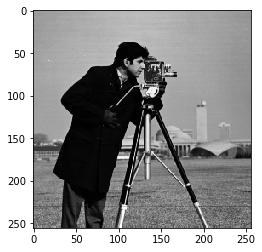

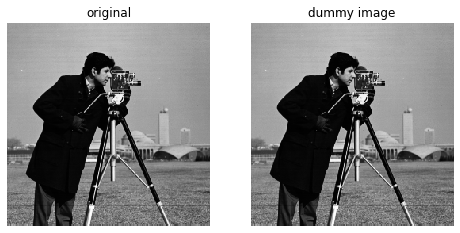

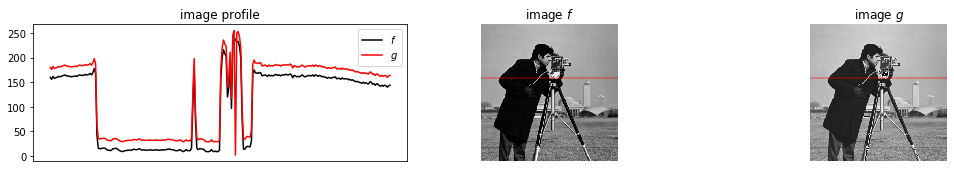

In [4]:
# read an image
f = io.imread('../images/cameraman.png')

# Display the image with grayscale colormap
imshow(f)

# Create a dummy processed image
g = f+20

# Compare image f and g
plot_comparison(f, f, "dummy image")

# Compare image f and g, plotting also a profile of the image.
# You can change the line considered for plotting the profile with the parameter l.
l = 100
imshow_hprofile(f, g, l)



## Structuring element
- Have a look at the code below in which it is shown how to define SEs with different shapes.
- Define a few structuring elements and see the masks produced. You can visualize a SE s using imshow(getnhood(s)).


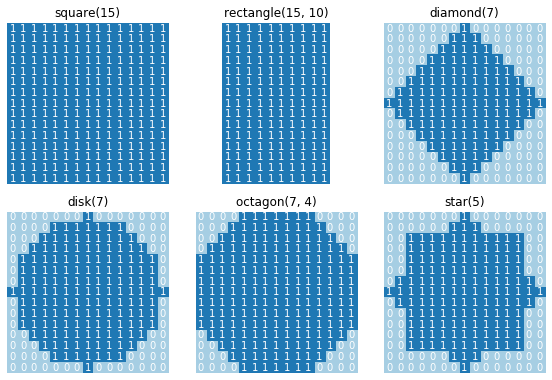

In [5]:
# define structuring elements with different shapes

# Generate 2D structuring elements.
struc_2d = {
    "square(15)": square(15),
    "rectangle(15, 10)": rectangle(15, 10),
    "diamond(7)": diamond(7),
    "disk(7)": disk(7),
    "octagon(7, 4)": octagon(7, 4),
    "star(5)": star(5)
}

# Visualize the elements.
fig = plt.figure(figsize=(8, 8))

idx = 1
for title, struc in struc_2d.items():
    ax = fig.add_subplot(3, 3, idx)
    ax.imshow(struc, cmap="Paired", vmin=0, vmax=12)
    for i in range(struc.shape[0]):
        for j in range(struc.shape[1]):
            ax.text(j, i, struc[i, j], ha="center", va="center", color="w")
    ax.set_axis_off()
    ax.set_title(title)
    idx += 1

fig.tight_layout()
plt.show()

### **Question**
An SE defines the neighborhood considered for each pixel.
Define the SE corresponding to the:
- **4-connectivity**: a pixel is considered to be connected to the four adjacent pixels in the north, south, east, west direction
- **8-connectivity**: a pixel is considered to be connected to the eight neighboring pixels

*Hint: consider the disk shape for the 4-connectivity.*

In [6]:
# your code here


## Morphological operators
Some basic operators are listed below. $B$ is a structuring element and $\overline{B}$ is the reflected SE (i.e., rotation of $B$ of 180 degrees around its origin). Load the cameraman image. Apply each operator to the image and see the effects.
- Erosion $\epsilon_B(f)$ with `erosion`.
- Dilation $\delta_B(f)$  with `dilation`.
- Opening $\gamma_B (f)=\delta_{\overline{B}}~[\epsilon_B(f)]$ with `opening`.
- Closing $\phi_B (f)=\epsilon_{\overline{B}}~[\delta_B(f)]$ with `closing`.
- White Top Hat (Residues of an opening)  $WTH(f)=f - \gamma_B(f)$, `white_tophat`.
- Black Top Hat (Residues of a closing)  $BTH(f)=\phi_B( f ) - f$, `black_tophat` .

Analyze the results also by looking at how a profile is affected by the processing.


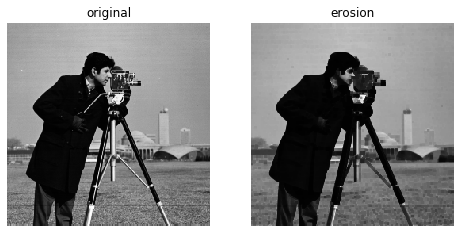

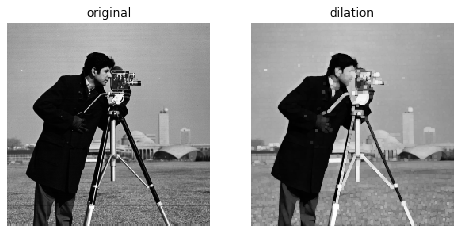

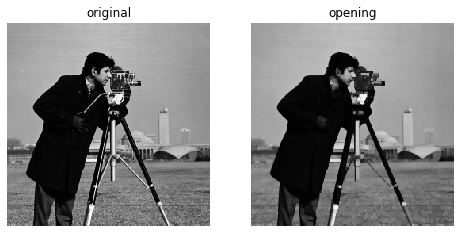

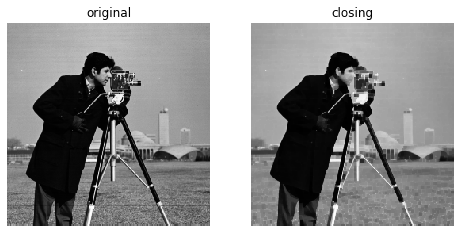

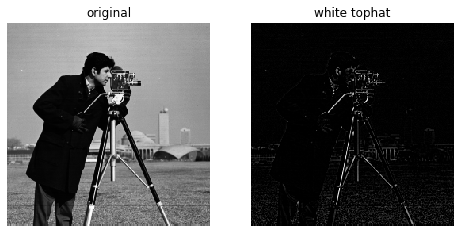

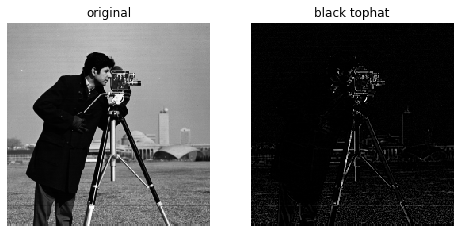

In [7]:
# define a SE
SE = square(3)

f_ero = erosion(f, SE)
plot_comparison(f, f_ero, 'erosion')

f_dil = dilation(f, SE)
plot_comparison(f, f_dil, 'dilation')

f_open = opening(f, SE)
plot_comparison(f, f_open, 'opening')

f_close = closing(f, SE)
plot_comparison(f, f_close, 'closing')

f_wth = white_tophat(f, SE)
plot_comparison(f, f_wth, 'white tophat')

f_bth = black_tophat(f, SE)
plot_comparison(f, f_bth, 'black tophat')

## **Question**
- Change the shape and size of the structuring element and observe the effects that are produced in the image.
- Compare the effects when using an isotropic (i.e., same in all directions) SE such as a disk or square with respect to considering a directional 

In [8]:
# your code here


### Morphological gradient
The **morphological gradient** $\rho$ is defined as the difference between the result of a dilation and an erosion computed on an image with the same SE $B$. As for the approximations of the gradient with linear filters, the neighborhood defined by the SE is in general the smallest possible, typically corresponding to the image connectivity (e.g., 4- or 8-connectivity):
$$\rho_B(f) = \delta_B(f) - \epsilon_B(f).$$

**Question** Implement the morphological gradient and test it on an image.

In [9]:
# your code here


## Operators based on geodesic reconstruction
Opening and closing by reconstruction are morphological operators that allow to simplifly an image without distorting the shape of the regions (connected components) that were not entirely removed by the processing.

The definition of the two operators is reported below.
- **Opening by reconstruction**: $\gamma^R_B(f) = R_f^\delta(\epsilon_B(f))$
- **Closing by reconstruction**: $\phi^R_B(f) = R_f^\epsilon(\delta_B(f))$
with $R_f^\delta$ and $R_f^\epsilon$, the geodesic reconstruction by dilation and erosion, respectively, using the original image $f$ as mask.

**Question** Implement an opening and closing by reconstruction.

*Hint: Geodesic reconstruction is implmented in `scikit-image` by the `reconstruct` function.*

In [10]:
# your code here


## Other useful operators
Apply the following operations to the cameraman image.
- Manual image thresholding, with `B = f > t`, where `f` is the image and `t` the value of the threshold. 
- Automatic thresholding. The value of the thresold can also be computed automatically on the image. In this case the idea is that the estimated threshold "optimally" (with respect to some metric) separates the background from the image foreground. A well known example of this is the Otsu thresholding algorithm which aims at finding the threshold that separates the distribution of the pixels associated to the background to those of the foreground. It is assumed that background and foreground have distributions fairly far apart.
- Median filter, with `median`.
- Image complement. Taking the complement of an image can be done by the `~` operator. Example: `f_neg = ~f`
- Regions Labeling in a binary image, with `label`. This function will take as input a binary image and label all pixels belonging to each region associated to 1 (connected component) a different label (integer value). By default, the background is associated to 0. After labeling, all pixels belonging to the same region will be associated to the same label (color in the figure). This allows to extract regions from an image based on their label.


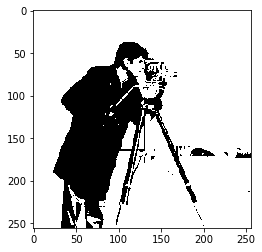

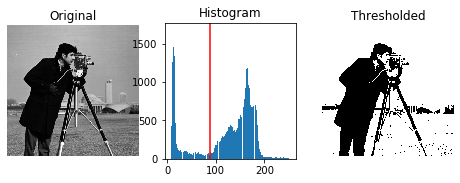

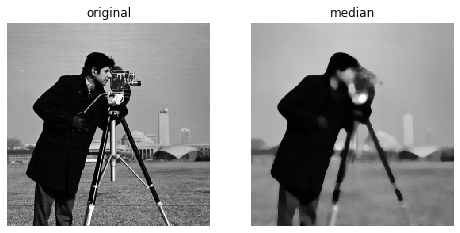

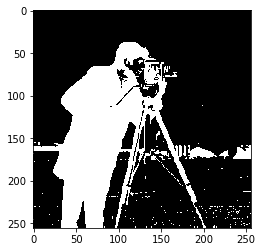

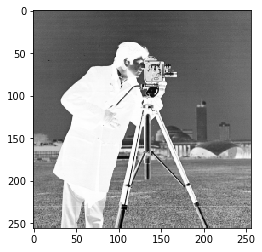

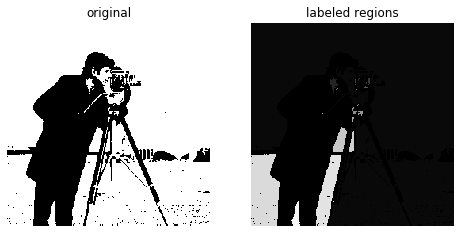

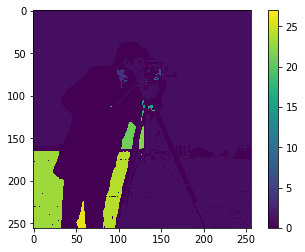

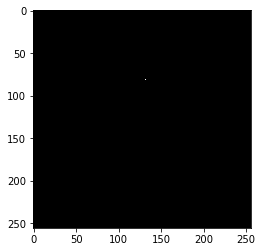

In [11]:
# Example manual thresholding
f_mt = f > 50
imshow(f_mt)

# Example of automatic thresholding (using the Otsu technique)
th = threshold_otsu(f)
f_th = f > th

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(f, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(f.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(th, color='r')

ax[2].imshow(f_th, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

# Median filter
SE = disk(5)
f_med = median(f, SE)
plot_comparison(f, f_med, "median")

# Image complement (negative of an image)
imshow(~f_th) # case of a binary image 
imshow(~f) # case of a grayscale image

# Label connected components.
# After the labeling, all pixels belonging to the same region will be associated to the same label (color in the figure). 
# This allows to extract regions from an image based on their label.
f_label = label(f_th)
plot_comparison(f_th, f_label, "labeled regions")
# Better to use a colored colormap for visualizing the result of the labeling
plt.figure()
plt.imshow(f_label)
plt.colorbar()
# Show the 10th region in the labeled image
imshow(f_label == 10)




# Processing (~1h)
In this part of the lab session, you will 
## Extracting the tablets
The goal is to design an algorithm for extracting the tablets (`tablets.png`) in order to detect the missing one. For this, we want to generate a binary image with ones at the pixels belonging to a tablet so one can easily count the number of regions in the image (e.g., using `label`) in order to estimate the number of tablets.

*Hint: Define a sequence of operations based on image thresholding (the threshold value can be defined manually) to isolate the tablets and post-processing (with which filter?) to remove spurious regions. Describe which operator you choose.*



In [12]:
# your code here


## Broken cookies
We would like to detect the broken cookies (`cookies broken.png`).
Propose a solution with the tools at your disposal and test it.

*Hint: exploit the fact that the broken cookies are slightly smaller than the others.*

In [13]:
# your code here


## Area of chocolates
The goal is to design an algorithm for counting and estimating the area (in number of pixel) of the chocolates (`chocos.jpg`).
- Let us first extract the chocolates. Similarly as before, we can process the image in order to derive a binary image showing the objects of interest.
- How do you deal with the grid around the chocolates?
- Once you have a satisfactory binary image, use bwlabel for labeling the regions. The result of this operation is an image where the background is set to zero and each region has a different value.
- How can you exploit this image to compute the average area of the chocolates?  *Hint: you can consider using the histogram for this.*

In [14]:
# your code here

## Retina

- Load the image `retina.png`.
- Check the data type and the dynamics of the image values. *Hint: check image statistics (e.g., min, max...) and the histogram*.

Define an algorithm able to:
- Extract the optical nerve (the bright blob at the upper right corner of the image).
- [optional] Enhance the original image by improving its contrast since the parts of the image close to the borders are darker. *Hint. For doing this, you can first estimate the background of the image and you will then subtract it to the original image.(In order to avoid saturation, ensure do a cast in double before subtraction.)*
- [optional] Extract the vessel network.


In [15]:
# your code here

## [optional] Aligned cookies
Load the image `cookies_lines_misal.png`.
- During production, the cookies are aligned in columns. 
- Define an algorithm for automatically detecting the columns in which the cookies are not aligned.

In [16]:
# your code here

## [optional] Aligned cookies
Load the image `cookies_lines_misal.png`.
- During production, the cookies are aligned in columns. 
- Define an algorithm for detecting the columns in which the cookies are not aligned.

In [17]:
# your code here